# Imports

In [507]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform
import nengo
import pandas as pd

# Parametrisierung der Lernrate

In [508]:
def parametrize_learning_law(v0, vf, t0, tf, learning_type):
    assert learning_type in ('sigmoid', 'invtime', 'exp')

    #Matrix zur Speicherung der parametrisierten Lernrate für jeden Schritt
    y = np.zeros((tf - t0,))

    #Zeitschritte von 1 bis tf
    t = np.array([i for i in range(1, tf +1 )])

    #Unterscheidung nach Lernarten (sigmoid, invtime, exp)
    if learning_type == 'sigmoid':
        s = -np.floor(np.log10(tf)) * 10**(-(np.floor(np.log10(tf))))
        p = abs(s*10**(np.floor(np.log10(tf)) + np.floor(np.log10(tf))/2))
        y = v0 - (v0)/(1+np.exp(s*(t-(tf/p)))) + vf
    
    elif learning_type == 'invtime':
        B = (vf * tf - v0 * t0) / (v0 - vf)
        A = v0 * t0 + B * v0
        y = [A / (t[i] + B) for i in range(len(t))]
    
    #v0 = .9            #ursprünglicher Wert
    #vf = .01           #finaler Wert
    elif learning_type == 'exp':
        if v0 < 1:
            p = -np.log(v0)
        else:
            p = np.log(v0)
        y = v0 * np.exp(-t/(tf/p))

    return y

# Parameter

In [509]:
#Anzahl Ensembles
N_ENS = 2

#Anzahl der Neuronen in SOM
N_NEURONS = 50

#Wertebereich
RADIUS = 1.5

#Schrittweite der Nengo-Simulation
DT = .001

#Max Anzahl Epochen für inneres Lernen der SOM
MAX_EPOCHS_IN_LEARNING = 100

#Max Anzahl Epochen für äußeres Lernen der SOM
MAX_EPOCHS_XMOD_LEARNING = 100

#Anzahl Samples für Training
N_SAMPLES = 1500

#Aktivitätsverfallrate
ETA = 1.

#Gewichtsverfallrate
XI = 1e-3

#Lernarten
LEARNING_TYPES = ['sigmoid', 'invtime', 'exp']

#Parametrisierung der Lernraten
sigma0 = N_NEURONS / 2. #ursprünglicher Wert
sigmaf = 1.             #finaler Wert
SIGMAT = parametrize_learning_law(v0=sigma0, vf=sigmaf, t0=1, tf=MAX_EPOCHS_IN_LEARNING, learning_type='invtime')
alpha0 = .9            #ursprünglicher Wert
alphaf = .01           #finaler Wert
ALPHAT = parametrize_learning_law(v0=alpha0, vf=alphaf, t0=1, tf=MAX_EPOCHS_IN_LEARNING, learning_type='exp')

#Vorhandene Sensoren
SENSORES = ['x', 'y']
assert len(SENSORES) == N_ENS

# Standartabweichungen zur Berechnungen der Gewichtsänderungen
SIGMA_DEF =.045

# Matrizen für X-Korrelation zwischen den Neuronen werden abgespeichert, um als transform-Parameter auf Ensembles angewandt werden zu können
W_CROSS = uniform(0, 1, (N_NEURONS, N_NEURONS))
XMOD_WEIGHTS = {}
for i, _ in enumerate(SENSORES):
    XMOD_WEIGHTS[i] = W_CROSS / W_CROSS.sum()

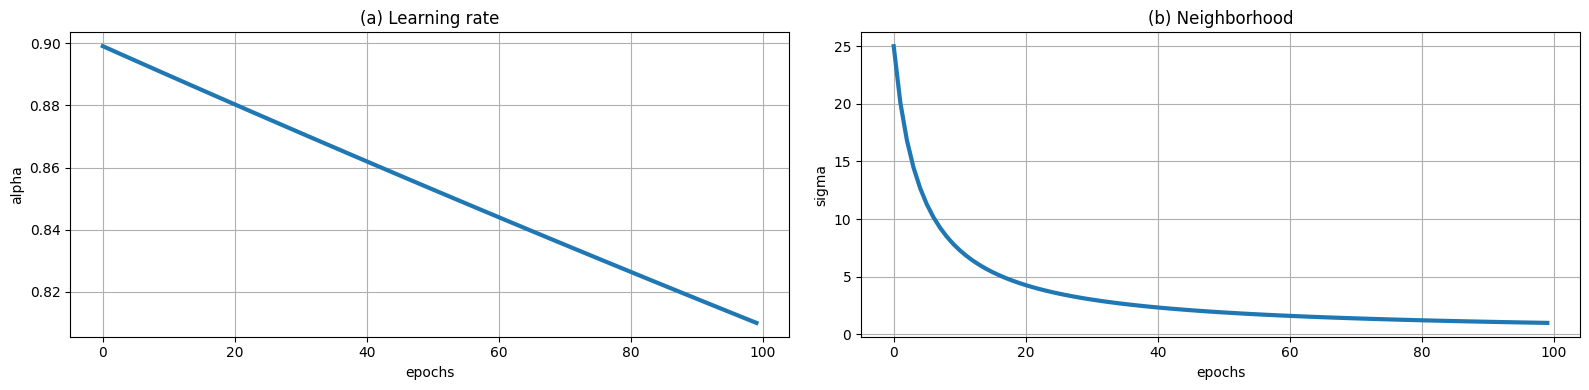

In [511]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(ALPHAT, linewidth=3)
plt.grid()
plt.title('(a) Learning rate')
plt.xlabel('epochs')
plt.ylabel('alpha')

plt.subplot(1, 2, 2)
plt.plot(SIGMAT, linewidth=3)
plt.grid()
plt.title('(b) Neighborhood')
plt.xlabel('epochs')
plt.ylabel('sigma')

plt.tight_layout()
plt.subplots_adjust(wspace=.1)
plt.show()

# Sensordaten

In [512]:
def generate_test_data():
    data = {}
    data['x'] = np.array(np.random.uniform(-1,1, N_SAMPLES))
    data['y'] = np.array([x**3 for _,x in enumerate(data['x'])])
    return data

In [513]:
data = generate_test_data()
sensory_data = np.column_stack((data['x'], data['y']))
sensory_data

array([[ 3.89108918e-01,  5.89133278e-02],
       [ 5.77275155e-01,  1.92374985e-01],
       [-8.52916899e-01, -6.20469099e-01],
       ...,
       [ 1.19977721e-01,  1.72703772e-03],
       [ 6.87334300e-02,  3.24716272e-04],
       [-4.27052768e-01, -7.78833502e-02]])

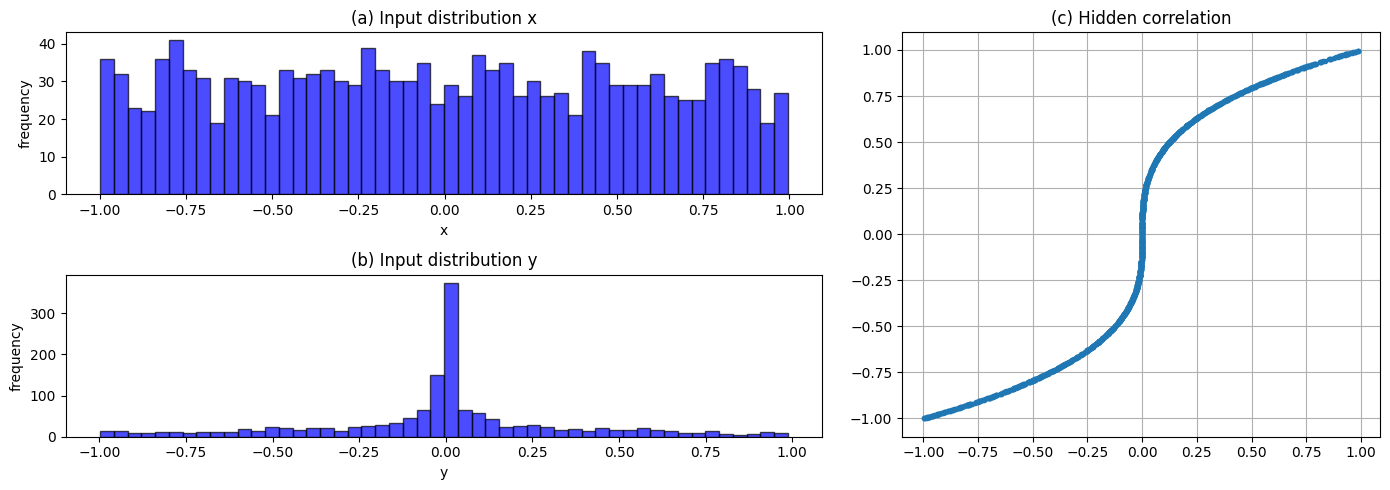

In [514]:
plt.figure(figsize=(14, 5))

plt.subplot2grid((2, 5), (0, 0), colspan=3)
plt.title('(a) Input distribution x')
plt.hist(data['x'], bins=50, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel('x')
plt.ylabel('frequency')

plt.subplot2grid((2, 5), (1, 0), colspan=3)
plt.title('(b) Input distribution y')
plt.hist(data['y'], bins=50, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel('y')
plt.ylabel('frequency')

plt.subplot2grid((2, 5), (0, 3), rowspan=2, colspan=2)
plt.plot(data['y'], data['x'], '.')
plt.title('(c) Hidden correlation')
plt.grid()

plt.tight_layout()
plt.subplots_adjust(wspace=.4)
plt.show()


# Lernalgorithmen

## Update-Activity

In [516]:
#für Ansatz, welcher winput, activity und std je als Ensemble implementiert
def update_activity_vector(winput, activity, std, datapoint):
    #Initialisierung des Aktivitätsvektors auf 0
    act_cur = np.zeros((N_NEURONS,))

    #hier kann teilen durch 0 auftreten, weshalb 0-Werte ersetzt werden
    std = np.maximum(std, 1e-8)
    act_cur = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-np.square(datapoint - winput) / (2 * np.square(std)))

    #Normalisierung des Aktivitätsvektors der Population
    if act_cur.sum() != 0:
        act_cur /= act_cur.sum()
    
    #Aktualisierung der Aktivität für die nächste Iteration
    activity = (1 - ETA) * activity + ETA * act_cur
    return activity

## Inneres Lernen

In [518]:
#für Ansatz, welcher winput, activity und std je als Ensemble implementiert
def inner_learning(winputs, activities, stds, epoch):
    #Kernelwert (Differenz zw. Pos. des aktuellen Neurons und der Pos. des Neurons mit der höchsten Aktivität)
    hwi = np.zeros((N_NEURONS,))

    #Werte der Lernraten bleiben bei Schleifendurchläufe konstant und müssen so nur einmal gelesen werden
    alpha = ALPHAT[epoch-1]
    sigma = SIGMAT[epoch-1]

    #Faktor ändert sich nicht in Schleifendurchläufen und muss nur einmal berechnet werden
    factor = 1 / (np.sqrt(2 * np.pi) * sigma)

    for _, datapoint in enumerate(sensory_data): #iterieren über Datenpunkte
        for i in range(len(SENSORES)):
            # update the activity for the next iteration
            activities[i] = update_activity_vector(winputs[i], activities[i], stds[i], datapoint[i])

            #Bestimmung des Neurons mit höchster Aktivität (Gewinnerneuron)
            win_pos = np.argmax(activities[i])

            #Berechnung des Kernelwerts für Neuronen
            #einfacher Gauß'scher Kernel ohne Berücksichtigung der Begrenzungen
            hwi = np.exp(-np.square(np.arange(N_NEURONS) - win_pos) / (2 * sigma**2))

            #Aktualisierung der Gewichtungen der Neuronen
            winputs[i] += alpha * hwi * (datapoint[i] - winputs[i])

            #Aktualisierungen der std der Neuronen
            stds[i] += alpha * factor * hwi * (np.square(datapoint[i] - winputs[i]) - np.square(stds[i]))
    return (winputs, activities, stds)

## XMod-Lernen

### Hebbian

In [520]:
#für Ansatz, welcher winput, activity und std je als Ensemble implementiert
def hebbian_learning(winputs, activities, stds):
    for _, datapoint in enumerate(sensory_data):
        #Aktualisierung des Aktivitätsvektor
        for i in range(N_ENS):
            activities[i] = update_activity_vector(winputs[i], activities[i], stds[i], datapoint[i])

        #Hebb'sche Regel für Kreuzmodalität: Multiplikation der Aktivitäten
        XMOD_WEIGHTS[0] = (1 - XI) * XMOD_WEIGHTS[0] + XI * activities[0] * activities[1].T
        XMOD_WEIGHTS[1] = (1 - XI) * XMOD_WEIGHTS[1] + XI * activities[1] * activities[0].T
    
    return activities

### Covariance

In [522]:
#für Ansatz, welcher winput, activity und std je als Ensemble implementiert
def covariance_learning(winputs, activities, stds, epoch):
    #  mean activities for covariance learning
    avg_act = np.zeros((N_NEURONS, N_ENS))

    # Berechnung des Abfalls für den Mittelwert
    omega = .002 + .998 / (epoch + 2)

    for _, datapoint in enumerate(sensory_data):
        for i in range(N_ENS):
            #Aktualisierung des Aktivitätsvektor
            activities[i] = update_activity_vector(winputs[i], activities[i], stds[i], datapoint[i])
            # Berechnung des Abfalls für den Mittelwert
            avg_act[:, i] = (1 - omega) * avg_act[:, i] + omega * activities[i][:]

        #Kreuzmodale Hebb'sche Kovarianz-Lernregel: Aktualisierung der Gewichte basierenf auf Kovarianz
        XMOD_WEIGHTS[0] = (1 - XI) * XMOD_WEIGHTS[0] + XI * (activities[0] - \
                          avg_act[:, 0].reshape(N_NEURONS,1)) * (activities[1] - avg_act[:,1].reshape(N_NEURONS,1)).T
        XMOD_WEIGHTS[1] = (1 - XI) * XMOD_WEIGHTS[1] + XI * (activities[1] - \
                          avg_act[:, 1].reshape(N_NEURONS,1)) * (activities[0] - avg_act[:, 0].reshape(N_NEURONS,1)).T
        
    return activities

### Oja

In [524]:
#für Ansatz, welcher winput, activity und std je als Ensemble implementiert
def oja_learning(winputs, activities, stds):
    for _, datapoint in enumerate(sensory_data):
        #Aktualisierung des Aktivitätsvektor
        for i in range(N_ENS):
            activities[i] = update_activity_vector(winputs[i], activities[i], stds[i], datapoint[i])

        # Oja'sche lokale PCA-Lernregel
        XMOD_WEIGHTS[0] = ((1 - XI) * XMOD_WEIGHTS[0] + XI * activities[0] * activities[1].T) / \
                          np.sqrt(sum(sum((1 - XI) * XMOD_WEIGHTS[0] + XI * activities[0] * activities[1].T)))
        XMOD_WEIGHTS[1] = ((1 - XI) * XMOD_WEIGHTS[1] + XI * activities[1] * activities[0].T) / \
                          np.sqrt(sum(sum((1 - XI) * XMOD_WEIGHTS[1] + XI * activities[1] * activities[0].T)))
        
    return activities

# Nengo-Netzwerk

In [526]:
class LearnProcess(nengo.Process):
    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        def step(t, x):
            epoch = int(t/DT)

            if epoch == 0: #wenn erster Durchlauf, Werte der Neuronen initialisieren
                winputs = np.zeros((N_ENS, N_NEURONS))
                activities = np.zeros((N_ENS, N_NEURONS))
                stds = np.ones((N_ENS, N_NEURONS)) * SIGMA_DEF
            else:
                winputs = np.array([x[:N_NEURONS], x[N_NEURONS:N_NEURONS*2]])
                activities = np.array([x[N_NEURONS*2:N_NEURONS*3], x[N_NEURONS*3:N_NEURONS*4]])
                stds = np.array([x[N_NEURONS*4:N_NEURONS*5], x[N_NEURONS*5:N_NEURONS*6]])
            
            #Inneres Lernen
            if epoch <= MAX_EPOCHS_IN_LEARNING:
                (winputs, activities, stds) = inner_learning(winputs, activities, stds, epoch)

            #XMOD-Lernen
            activities = \
            covariance_learning(winputs, activities, stds, epoch)
            #oja_learning1(winputs, activities, stds)
            #hebbian_learning1(winputs, activities, stds)

            return np.concatenate((winputs.flatten(), activities.flatten(), stds.flatten()), axis=None)
        return step

In [527]:
with nengo.Network() as net:
    #Repräsentation der WInput-Vektoren als Ensembles
    winput_x = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)
    winput_y = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)

    #Repräsentation der Aktivitäts-Vektoren als Ensembles
    activity_x = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)
    activity_y = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS)

    #Repräsentation der std-Vektoren als Ensembles
    std_x = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS, intercepts=nengo.dists.Uniform(0.,1.), encoders=nengo.dists.Choice([[1]]), max_rates=nengo.dists.Uniform(400,500))
    std_y = nengo.networks.EnsembleArray(N_NEURONS*50, n_ensembles=N_NEURONS, radius=RADIUS, intercepts=nengo.dists.Uniform(0.,1.), encoders=nengo.dists.Choice([[1]]), max_rates=nengo.dists.Uniform(400,500))

    learn_node = nengo.Node(LearnProcess(), size_in=N_NEURONS*N_ENS*3, size_out=N_NEURONS*N_ENS*3)

    #Verbindungen von Neuronen der Ensembles zur Lernmethode ...
    nengo.Connection(winput_x.output, learn_node[:N_NEURONS])
    nengo.Connection(winput_y.output, learn_node[N_NEURONS:N_NEURONS*2])
    nengo.Connection(activity_x.output, learn_node[N_NEURONS*2:N_NEURONS*3])
    nengo.Connection(activity_y.output, learn_node[N_NEURONS*3:N_NEURONS*4])
    nengo.Connection(std_x.output, learn_node[N_NEURONS*4:N_NEURONS*5])
    nengo.Connection(std_y.output, learn_node[N_NEURONS*5:N_NEURONS*6])
    # ... und wieder zurück
    nengo.Connection(learn_node[:N_NEURONS], winput_x.input)
    nengo.Connection(learn_node[N_NEURONS:N_NEURONS*2], winput_y.input)
    nengo.Connection(learn_node[N_NEURONS*2:N_NEURONS*3], activity_x.input)
    nengo.Connection(learn_node[N_NEURONS*3:N_NEURONS*4], activity_y.input)
    nengo.Connection(learn_node[N_NEURONS*4:N_NEURONS*5], std_x.input)
    nengo.Connection(learn_node[N_NEURONS*5:N_NEURONS*6], std_y.input)


    #Proben
    p_winput_x = nengo.Probe(winput_x.output)
    p_winput_y = nengo.Probe(winput_y.output)
    p_activity_x = nengo.Probe(activity_x.output)
    p_activity_y = nengo.Probe(activity_y.output)
    p_std_x = nengo.Probe(std_x.output)
    p_std_y = nengo.Probe(std_y.output)

In [528]:
with nengo.Simulator(net, dt=DT) as s:
    s.run_steps(MAX_EPOCHS_XMOD_LEARNING)

Build finished in 0:06:57.                                                      
Simulation finished in 0:00:58.                                                 


# Visualisierung

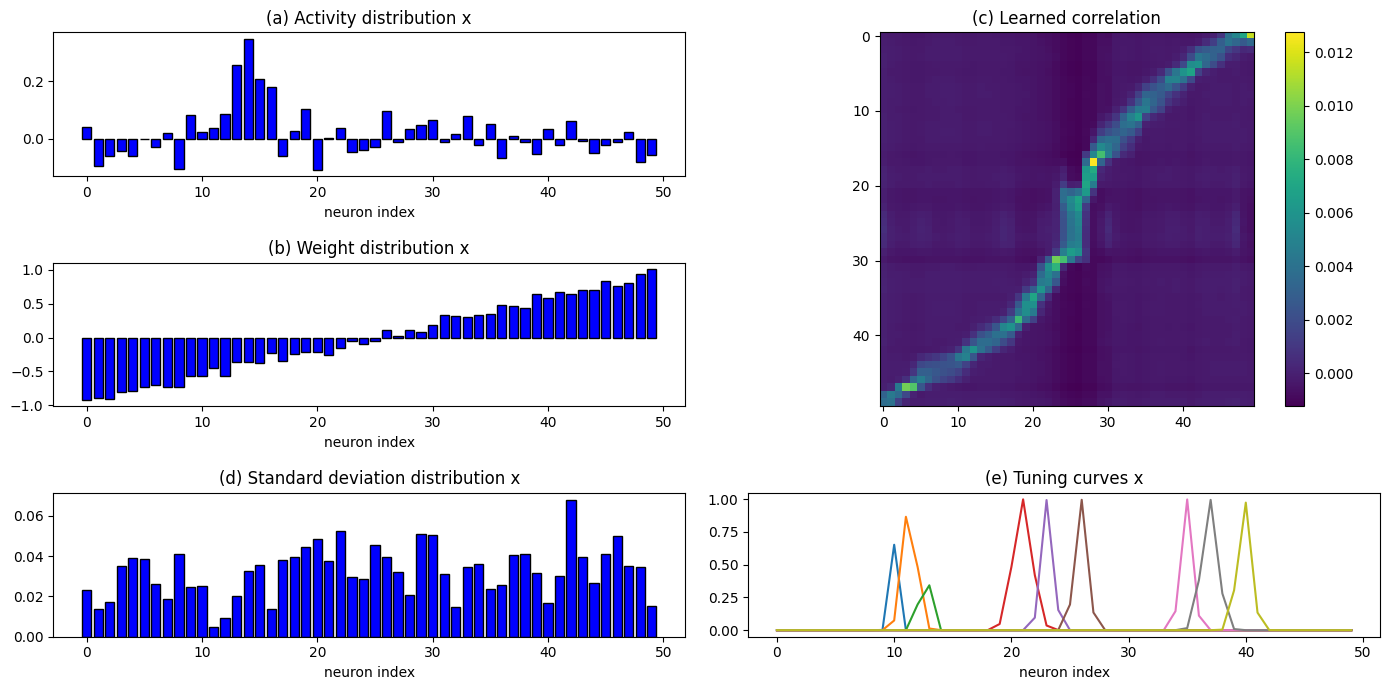

In [537]:
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
pref = [1, 3, 7, 20, 23, 27, 41, 45, 48]

plt.figure(figsize=(14, 7))

plt.subplot2grid((3, 2), (0, 0))
plt.bar(range(N_NEURONS), s.data[p_activity_x][-1], facecolor="blue", edgecolor="black")
plt.title('(a) Activity distribution x')
plt.xlabel('neuron index')

plt.subplot2grid((3, 2), (1, 0))
plt.bar(range(N_NEURONS), s.data[p_winput_x][-1], facecolor="blue", edgecolor="black")
plt.title('(b) Weight distribution x')
plt.xlabel('neuron index')

plt.subplot2grid((3, 2), (0, 1), rowspan=2)
plt.title('(c) Learned correlation')
plt.imshow(XMOD_WEIGHTS[0].T, cmap='viridis')
plt.colorbar()

plt.subplot2grid((3, 2), (2, 0))
plt.bar(range(N_NEURONS), s.data[p_std_x][-1], facecolor="blue", edgecolor="black")
plt.title('(d) Standard deviation distribution x')
plt.xlabel('neuron index')

plt.subplot2grid((3, 2), (2, 1))
plt.title('(e) Tuning curves x')
plt.xlabel('neuron index')
v_pref = np.sort(s.data[p_winput_x][-1],axis=0)
for i in range(len(pref)):
    i_pref = pref[i]
    fx = np.exp(-(x - v_pref[i_pref])**2 / (2 * s.data[p_std_x][-1][i_pref]**2))
    plt.plot([x for x in range(N_NEURONS)],fx)

plt.tight_layout()
plt.subplots_adjust(hspace=.6, wspace=.1)
plt.show()

### Visualisierung activity-Vektoren

Text(0, 0.5, 'Wert')

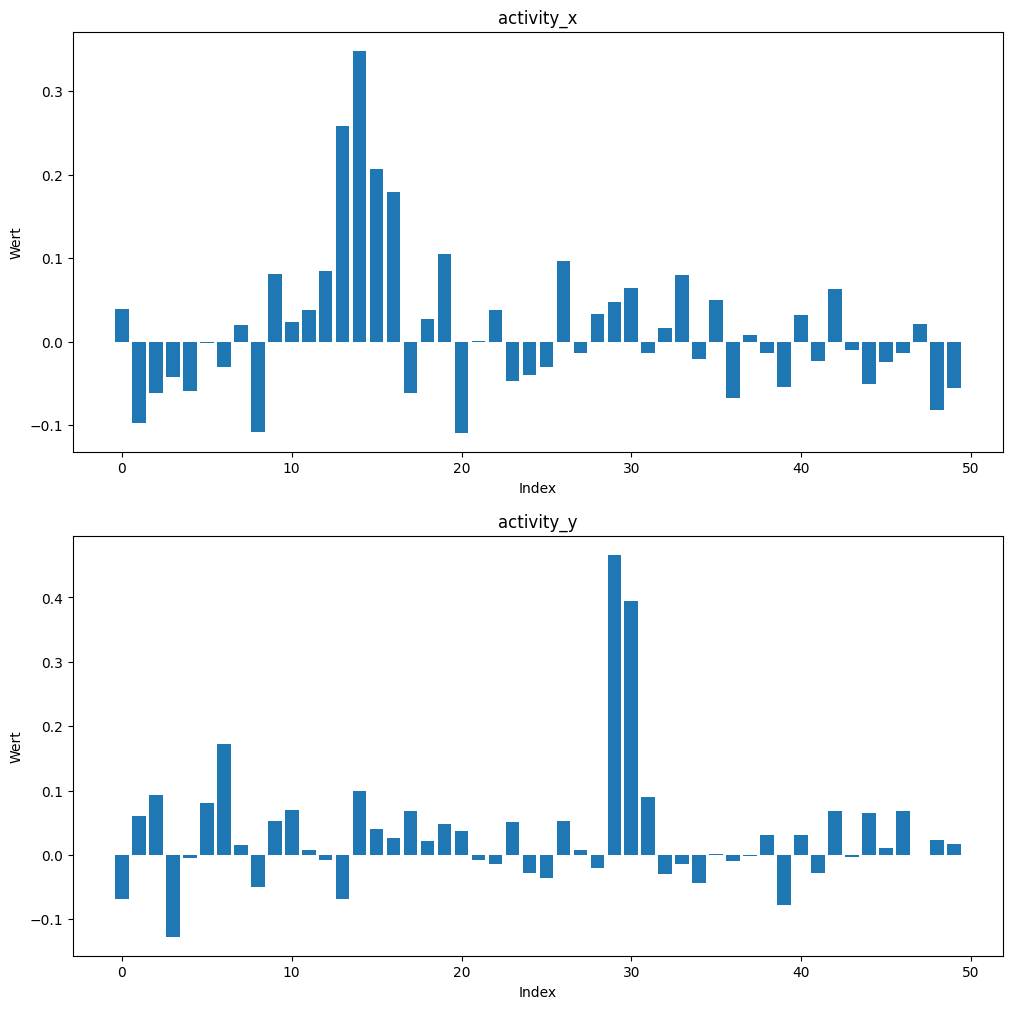

In [530]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), s.data[p_activity_x][-1])
plt.title('activity_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), s.data[p_activity_y][-1])
plt.title('activity_y')
plt.xlabel('Index')
plt.ylabel('Wert')

### Visualisierung winput-Vektoren

Text(0, 0.5, 'Wert')

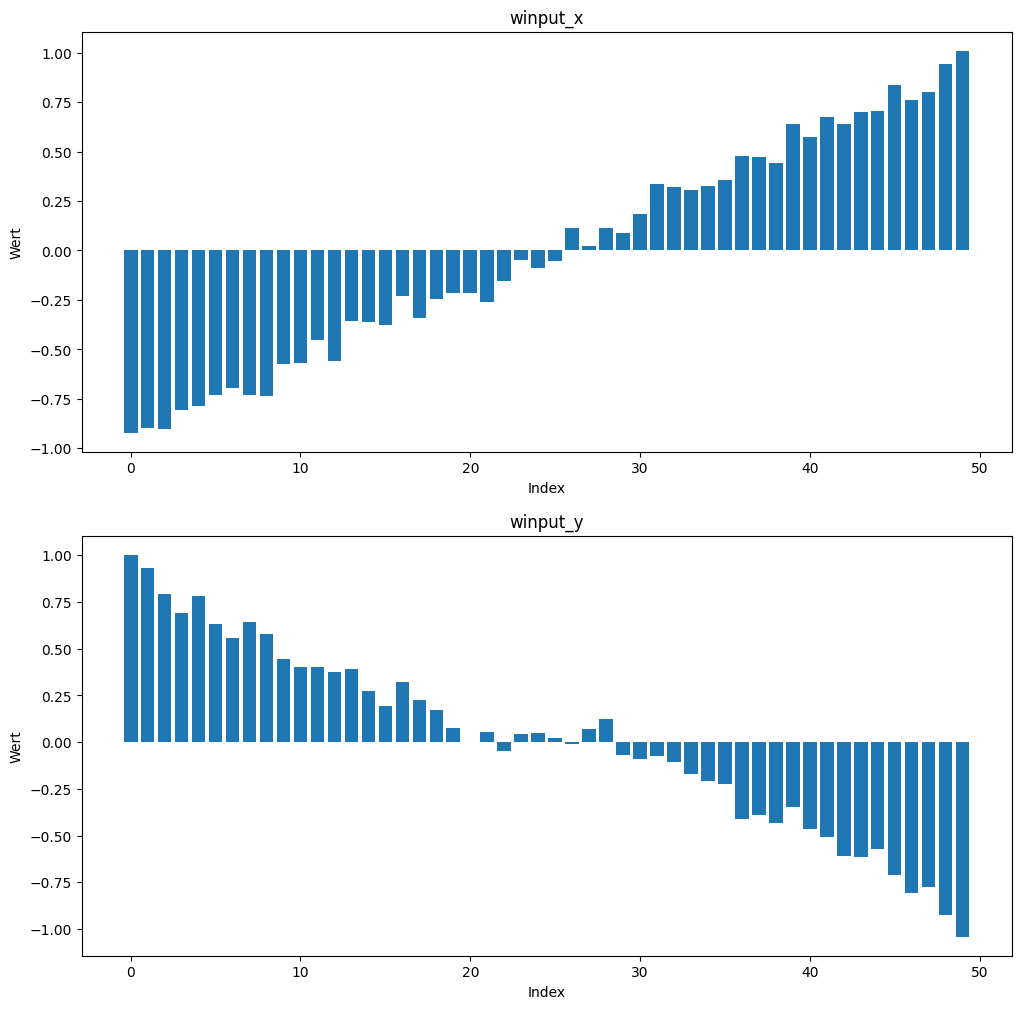

In [531]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), s.data[p_winput_x][-1])
plt.title('winput_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), s.data[p_winput_y][-1])
plt.title('winput_y')
plt.xlabel('Index')
plt.ylabel('Wert')

(array([1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 2., 1., 0., 1., 2., 2., 0.,
        1., 0., 0., 2., 1., 1., 3., 1., 2., 4., 2., 1., 1., 1., 1., 1., 1.,
        1., 3., 1., 0., 0., 2., 1., 1., 1., 0., 2., 0., 0., 0., 1., 1.]),
 array([-1.04075921, -0.99988748, -0.95901575, -0.91814402, -0.87727229,
        -0.83640057, -0.79552884, -0.75465711, -0.71378538, -0.67291365,
        -0.63204193, -0.5911702 , -0.55029847, -0.50942674, -0.46855502,
        -0.42768329, -0.38681156, -0.34593983, -0.3050681 , -0.26419638,
        -0.22332465, -0.18245292, -0.14158119, -0.10070946, -0.05983774,
        -0.01896601,  0.02190572,  0.06277745,  0.10364917,  0.1445209 ,
         0.18539263,  0.22626436,  0.26713609,  0.30800781,  0.34887954,
         0.38975127,  0.430623  ,  0.47149473,  0.51236645,  0.55323818,
         0.59410991,  0.63498164,  0.67585336,  0.71672509,  0.75759682,
         0.79846855,  0.83934028,  0.880212  ,  0.92108373,  0.96195546,
         1.00282719]),
 <BarContainer object

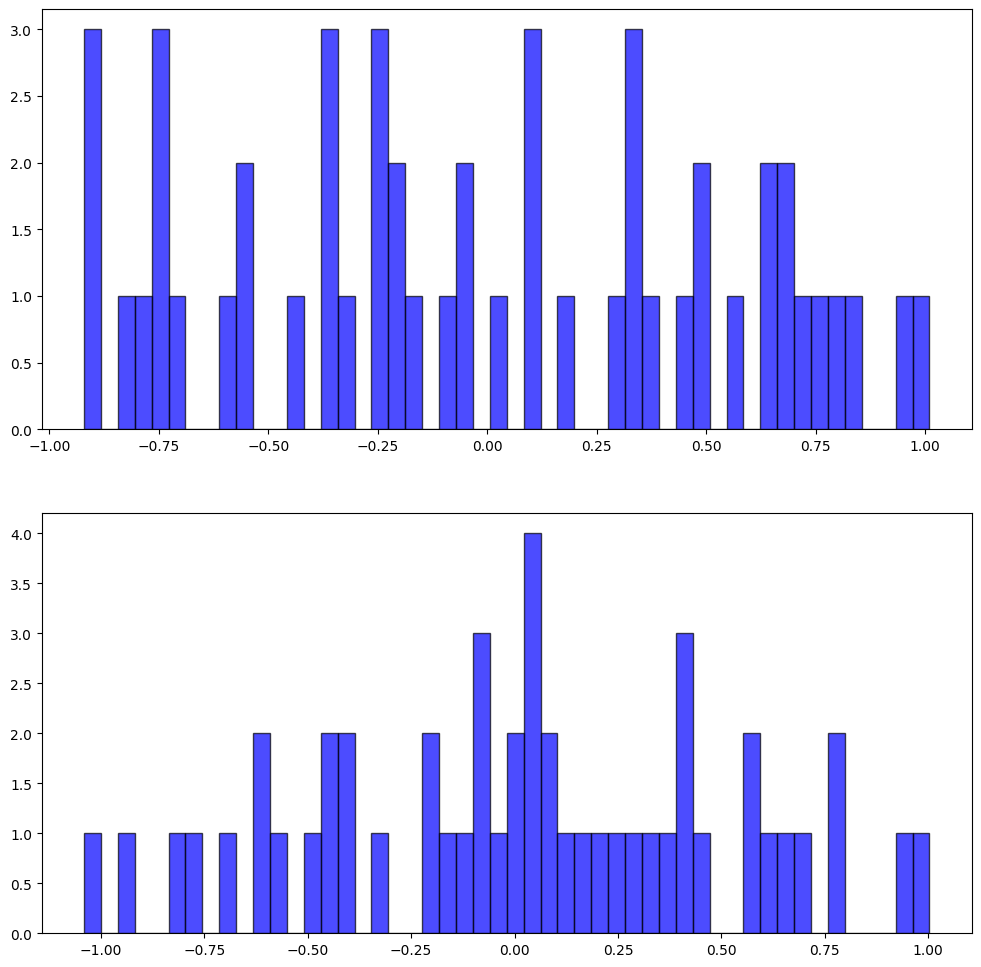

In [532]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.hist(s.data[p_winput_x][-1],bins=50,facecolor="blue", edgecolor="black", alpha=0.7)

plt.subplot(2, 1, 2)
plt.hist(s.data[p_winput_y][-1],bins=50,facecolor="blue", edgecolor="black", alpha=0.7)

/var/folders/fh/sm_pc8q53k98_ng1_m96z2900000gn/T/ipykernel_32866/1391271329.py:17: RuntimeWarning: divide by zero encountered in divide
  fx = np.exp(-(x - v_pref)**2 / (2 * s.data[p_std_y][-1][i]**2))


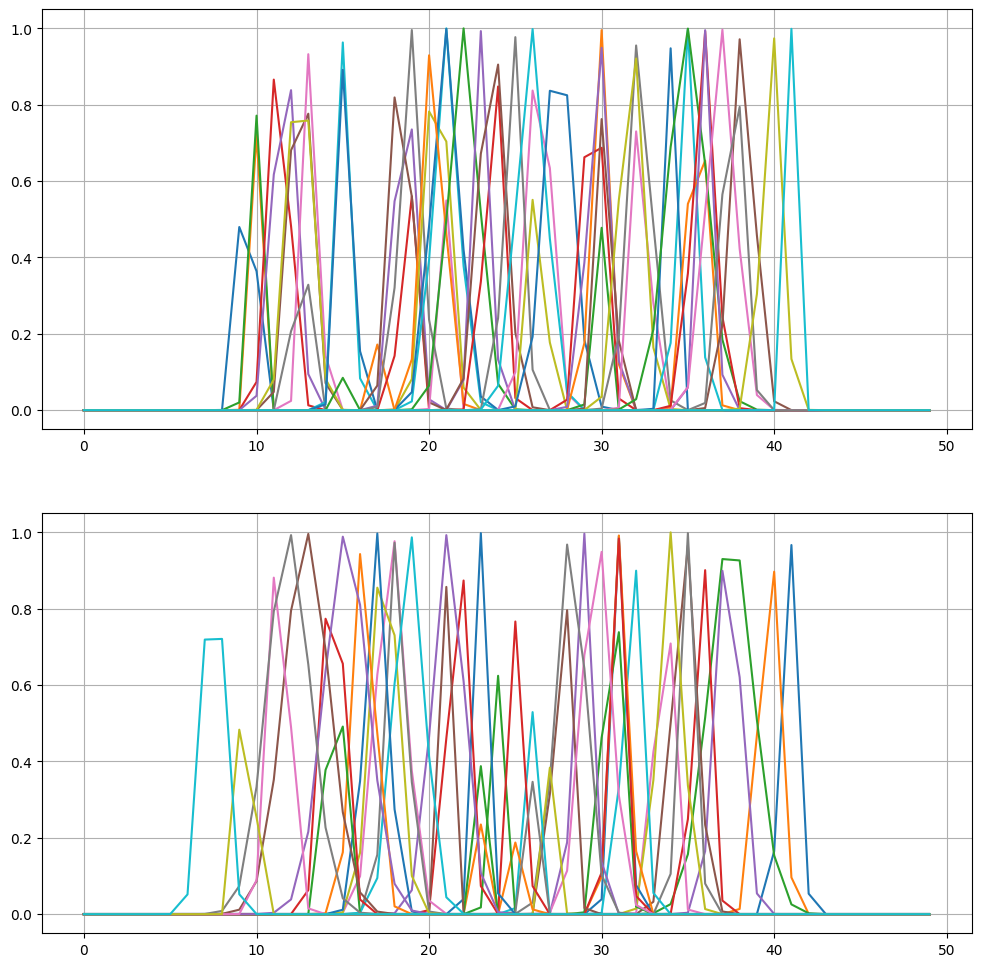

In [533]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.grid()
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
for i in range(N_NEURONS):
    # extract the preferred values (wight vector) of each neuron
    v_pref = s.data[p_winput_x][-1][i]
    fx = np.exp(-(x - v_pref)**2 / (2 * s.data[p_std_x][-1][i]**2))
    plt.plot([x for x in range(N_NEURONS)], fx)
    
plt.subplot(2, 1, 2)
plt.grid()
x = np.linspace(-RADIUS, RADIUS, N_NEURONS)
for i in range(N_NEURONS):
    # extract the preferred values (wight vector) of each neuron
    v_pref = s.data[p_winput_y][-1][i]
    fx = np.exp(-(x - v_pref)**2 / (2 * s.data[p_std_y][-1][i]**2))
    plt.plot([x for x in range(N_NEURONS)], fx)

### Visualisierung std-Vektoren

Text(0, 0.5, 'Wert')

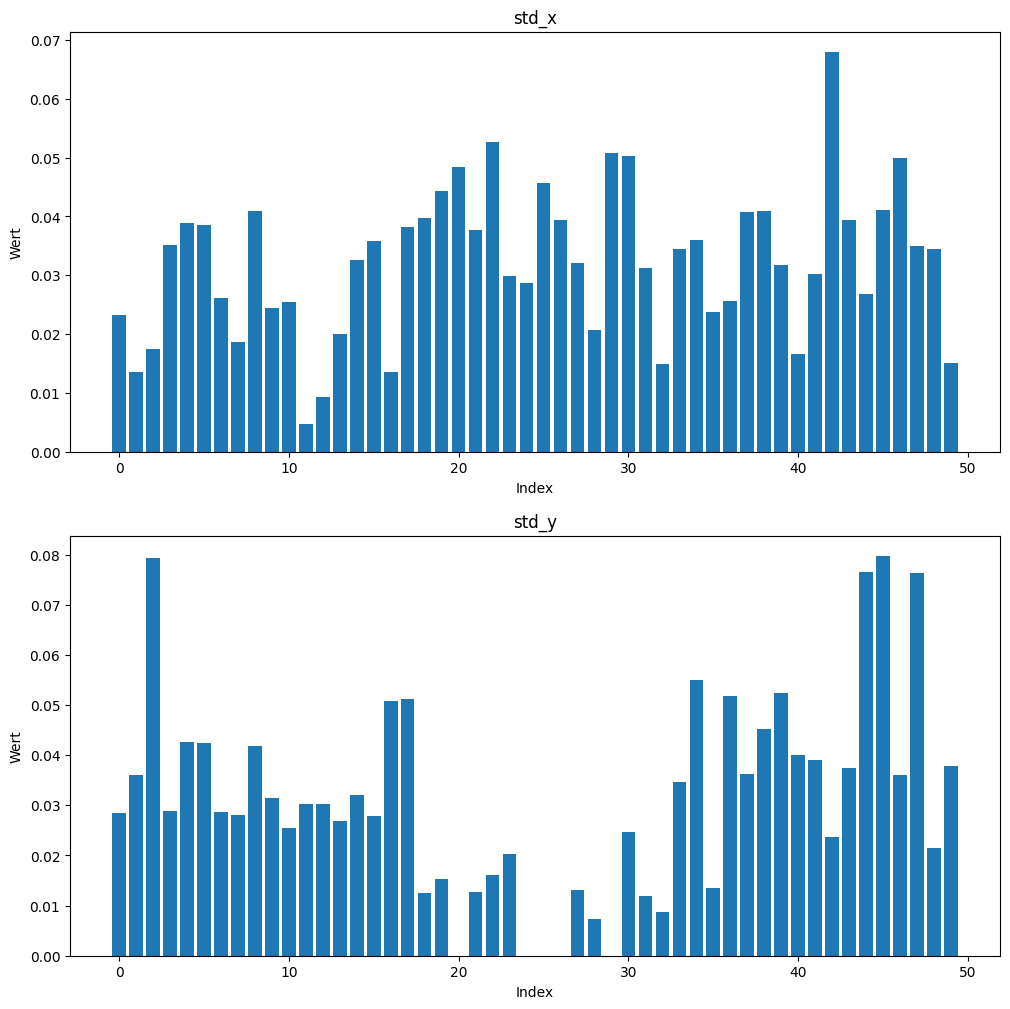

In [534]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.bar(range(N_NEURONS), s.data[p_std_x][-1])
plt.title('std_x')
plt.xlabel('Index')
plt.ylabel('Wert')

plt.subplot(2, 1, 2)
plt.bar(range(N_NEURONS), s.data[p_std_y][-1])
plt.title('std_y')
plt.xlabel('Index')
plt.ylabel('Wert')

### Visualisierung xmod-Matrizen

In [535]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.imshow(XMOD_WEIGHTS[0].T, cmap='viridis')
plt.colorbar() 
plt.title('XMOD_WEIGHTS x') 
plt.xlabel('Spaltenindex')
plt.ylabel('Zeilenindex')

plt.subplot(2, 1, 2)
plt.imshow(XMOD_WEIGHTS[1].T, cmap='viridis')
plt.colorbar() 
plt.title('XMOD_WEIGHTS y') 
plt.xlabel('Spaltenindex')
plt.ylabel('Zeilenindex')

Text(0, 0.5, 'Zeilenindex')

Error in callback <function flush_figures at 0x117ecee80> (for post_execute):


KeyboardInterrupt: 